In [1]:
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict


random.seed(0)
np.random.seed(0)

# Deterministic Method

In [2]:
def is_self_avoiding(walk):
    """Check if a walk is self-avoiding."""
    return len(walk) == len(set(walk))

def generate_saws(current_walk, L, visited):
    """Recursively generate all self-avoiding walks of length L."""
    if len(current_walk) == L + 1:
        return [current_walk]
    
    last_x, last_y = current_walk[-1]
    saws = []
    
    # Possible moves: up, down, left, right
    for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
        next_x, next_y = last_x + dx, last_y + dy
        if (next_x, next_y) not in visited:
            visited.add((next_x, next_y))
            saws.extend(generate_saws(current_walk + [(next_x, next_y)], L, visited))
            visited.remove((next_x, next_y))
    
    return saws

def count_saws(L):
    """Count the number of self-avoiding walks of length L."""
    initial_walk = [(0, 0)]
    visited = set(initial_walk)
    saws = generate_saws(initial_walk, L, visited)
    return len(saws)

# Compute c_L for L from 1 to 10
for L in range(1, 11):
    c_L = count_saws(L)
    print(f"c_{L} = {c_L}")

c_1 = 4
c_2 = 12
c_3 = 36
c_4 = 100
c_5 = 284
c_6 = 780
c_7 = 2172
c_8 = 5916
c_9 = 16268
c_10 = 44100


# Basic Monte Carlo I

In [3]:
def is_self_avoiding(walk):
    """Check if a walk is self-avoiding (no repeated vertices)."""
    return len(walk) == len(set(walk))

def generate_random_walk(L):
    """Generate a random walk of length L starting at (0, 0)."""
    walk = [(0, 0)]
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
    
    for _ in range(L):
        dx, dy = random.choice(directions)
        last_x, last_y = walk[-1]
        next_step = (last_x + dx, last_y + dy)
        walk.append(next_step)
    
    return walk

def monte_carlo_I(L, num_samples=10000):
    """Estimate the fraction of self-avoiding walks using Monte Carlo."""
    saw_count = 0
    
    for _ in range(num_samples):
        walk = generate_random_walk(L)
        if is_self_avoiding(walk):
            saw_count += 1
    
    fraction = saw_count / num_samples
    estimated_c_L = fraction * (4 ** L)  # Total possible walks: 4^L
    return fraction, estimated_c_L



In [4]:
c_L_df = pd.DataFrame({"estimated_c_L": [monte_carlo_I(i, 100000)[1] for i in range(1, 11)], 
              "deterministic_c_L": [count_saws(i) for i in range(1, 11)]})
c_L_df["percentage_error"] = (abs(c_L_df["estimated_c_L"] - c_L_df["deterministic_c_L"]) / c_L_df["deterministic_c_L"]) * 100 
c_L_df 

,estimated_c_L,deterministic_c_L,percentage_error
0,4.00000,4,0.000000
1,12.00416,12,0.034667
2,35.96224,36,0.104889
3,100.87936,100,0.879360
4,287.03744,284,1.069521
5,776.72448,780,0.419938
6,2163.67104,2172,0.383470
7,5846.46656,5916,1.175346
8,16171.66336,16268,0.592185
9,43935.33440,44100,0.373391


# Basic Monte Carlo II

In [6]:
def generate_dynamic_saw(L):
    """Generate a self-avoiding walk of length L using dynamic step selection."""
    walk = [(0, 0)]
    visited = set(walk)
    weight = 1.0  # Importance weight
    
    for _ in range(L):
        x, y = walk[-1]
        neighbors = [
            (x + 1, y), (x - 1, y),  # Right, Left
            (x, y + 1), (x, y - 1)    # Up, Down
        ]
        valid_moves = [n for n in neighbors if n not in visited]
        
        if not valid_moves:
            # Trapped: stay in place and adjust weight
            walk.append((x, y))
            continue	
        
        # Uniformly sample a valid move
        next_step = random.choice(valid_moves)
        walk.append(next_step)
        visited.add(next_step)
        
        # Update weight (multiply by inverse probability)
        weight *= len(valid_moves)
    
    return walk, weight

def monte_carlo_II(L, num_samples=10000):
    """Estimate c_L using importance sampling."""
    total_weight = 0.0
    
    for _ in range(num_samples):
        _, weight = generate_dynamic_saw(L)
        total_weight += weight
    
    # Average weight approximates c_L
    return total_weight / num_samples


In [7]:
c_L_df2 = pd.DataFrame({"estimated_c_L": [monte_carlo_II(i, 100000) for i in range(1, 11)], 
              "deterministic_c_L": [count_saws(i) for i in range(1, 11)]})
c_L_df2["percentage_error"] = (abs(c_L_df2["estimated_c_L"] - c_L_df2["deterministic_c_L"]) / c_L_df2["deterministic_c_L"]) * 100 
c_L_df2

,estimated_c_L,deterministic_c_L,percentage_error
0,4.00000,4,0.000000
1,12.00000,12,0.000000
2,36.00000,36,0.000000
3,99.94176,100,0.058240
4,283.87800,284,0.042958
5,779.52240,780,0.061231
6,2173.56696,2172,0.072144
7,5924.68020,5916,0.146724
8,16283.84796,16268,0.097418
9,44069.56632,44100,0.069011


# Advanced Monte Carlo Methods

In [8]:
known_mu = 2.638158533032790

## Importance Sampling

In [9]:
class RosenbluthSAW:
    """
    A class to estimate the connective constant μ using the Rosenbluth method.
    """

    def __init__(self, N=1000, max_L=100):
        self.N = N
        self.max_L = max_L
        self.directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]  # Possible steps

        # For storing results
        self.log_cL = np.zeros(max_L + 1)  # log(c_L) estimates
        self.mu_estimates = np.zeros(max_L + 1)  # μ estimates
        self.ess_history = []  # Effective Sample Size history
        self.accepted_ratio_history = []  # Ratio of accepted walks history

    def generate_walk(self, L):
        """
        Generate one self-avoiding walk (SAW) of length L using the Rosenbluth method.
        """
        walk = [(0, 0)]
        weight = 1.0

        for _ in range(L):
            current_pos = walk[-1]
            visited = set(walk)

            # Find available next steps
            available = []
            for dx, dy in self.directions:
                new_pos = (current_pos[0] + dx, current_pos[1] + dy)
                if new_pos not in visited:
                    available.append(new_pos)

            if not available:
                return None, 0.0  # Trapped walk

            # Choose uniformly at random from available steps
            next_pos = available[np.random.randint(len(available))]
            walk.append(next_pos)

            # Update weight
            weight *= len(available)

        return walk, weight

    def run(self):
        """
        Run the Rosenbluth simulation to estimate the connective constant μ.
        """
        with tqdm(range(1, self.max_L + 1), desc="Simulating Rosenbluth SAWs") as pbar:
            for L in pbar:
                total_weight = 0.0
                valid_walks = 0
                weights = []

                for _ in range(self.N):
                    walk, weight = self.generate_walk(L)
                    if weight > 0:
                        total_weight += weight
                        valid_walks += 1
                        weights.append(weight)

                # Estimate c_L as average weight
                if valid_walks > 0:
                    self.log_cL[L] = np.log(total_weight / valid_walks)
                else:
                    self.log_cL[L] = -np.inf

                # Estimate μ (connective constant)
                if L > 1:
                    self.mu_estimates[L] = np.exp(self.log_cL[L] / L)

                # Calculate ESS with exception handling
                try:
                    if weights:
                        weights = np.array(weights)
                        ess = (np.sum(weights) ** 2) / np.sum(weights ** 2)
                    else:
                        ess = 0
                except (ZeroDivisionError, OverflowError):
                    ess = 0  # Set ESS to 0 if an error occurs
                self.ess_history.append(ess)

                # Calculate ratio of accepted walks
                accepted_ratio = valid_walks / self.N
                self.accepted_ratio_history.append(accepted_ratio)

                # Update tqdm progress bar with postfix
                pbar.set_postfix({
                    "μ estimate": f"{self.mu_estimates[L]:.5f}",
                    "ESS": f"{ess:.2f}",
                    "Accepted Ratio": f"{accepted_ratio:.2%}"
                })

        return self.mu_estimates

### Simulation Run

In [10]:
# Run the simulation
start_time = time.time()
rosenbluth = RosenbluthSAW(N=1000, max_L=1000)
mu_estimates = rosenbluth.run()
end_time = time.time()

print(f"\nFinal μ estimate: {mu_estimates[-1]:.5f}")
print(f"Known μ ≈ {known_mu}")
print(f"Runtime: {end_time - start_time:.2f} seconds")


Simulating Rosenbluth SAWs:  37%|███▋      | 370/1000 [01:43<03:30,  2.99it/s, μ estimate=0.00000, ESS=0.00, Accepted Ratio=0.00%]  /tmp/ipykernel_116159/1630856259.py:78: RuntimeWarning: overflow encountered in scalar power
  ess = (np.sum(weights) ** 2) / np.sum(weights ** 2)
/tmp/ipykernel_116159/1630856259.py:78: RuntimeWarning: overflow encountered in square
  ess = (np.sum(weights) ** 2) / np.sum(weights ** 2)
/tmp/ipykernel_116159/1630856259.py:78: RuntimeWarning: invalid value encountered in scalar divide
  ess = (np.sum(weights) ** 2) / np.sum(weights ** 2)
Simulating Rosenbluth SAWs: 100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s, μ estimate=0.00000, ESS=0.00, Accepted Ratio=0.00%]


Final μ estimate: 0.00000
Known μ ≈ 2.63815853303279
Runtime: 320.07 seconds


#### $C_L$ Validation

In [11]:
c_L_df3 = pd.DataFrame({"estimated_c_L": np.exp(rosenbluth.log_cL[1:11]), 
              "deterministic_c_L": [count_saws(i) for i in range(1, 11)]})
c_L_df3["percentage_error"] = (abs(c_L_df3["estimated_c_L"] - c_L_df3["deterministic_c_L"]) / c_L_df3["deterministic_c_L"]) * 100 
c_L_df3

,estimated_c_L,deterministic_c_L,percentage_error
0,4.000000,4,0.000000
1,12.000000,12,0.000000
2,36.000000,36,0.000000
3,99.396000,100,0.604000
4,286.308000,284,0.812676
5,787.428000,780,0.952308
6,2186.028000,2172,0.645856
7,6091.394790,5916,2.964753
8,16273.413897,16268,0.033279
9,44552.286290,44100,1.025592


#### Plot of Evolution of Connective Constant

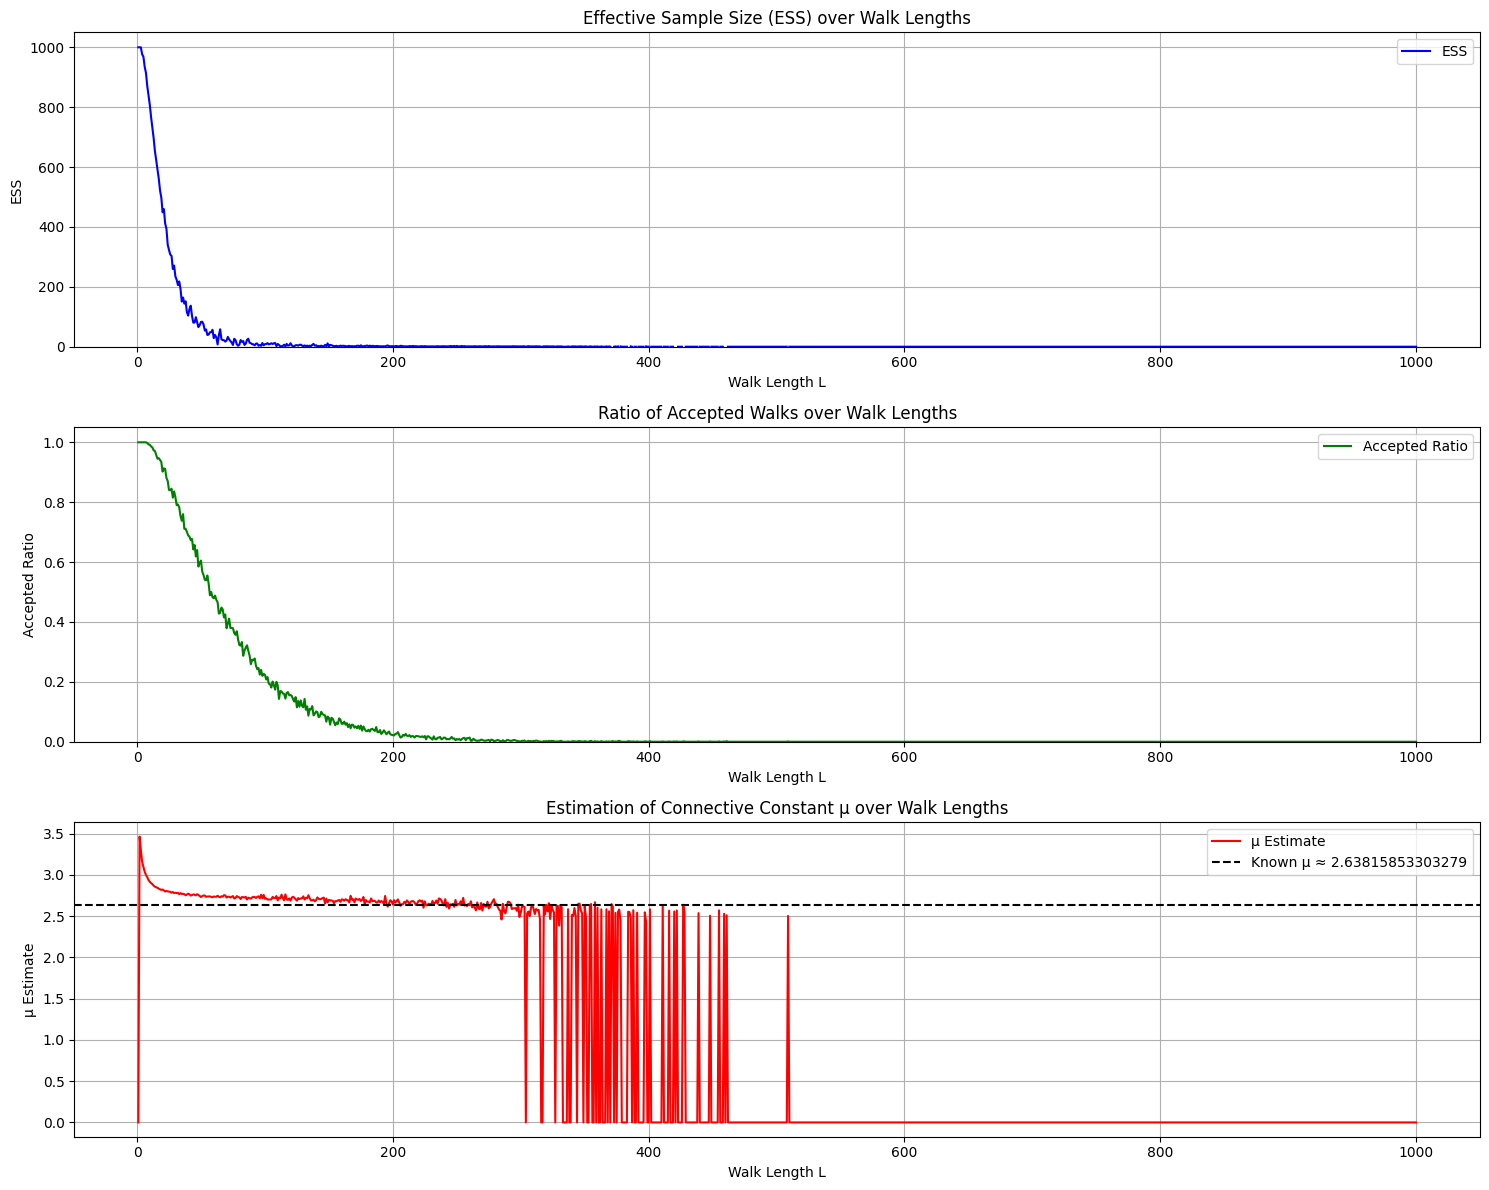

In [12]:
# Plot ESS, Ratio of Accepted Walks, and μ Estimates as Subplots
plt.figure(figsize=(15, 12))

# Subplot 1: Effective Sample Size (ESS)
plt.subplot(3, 1, 1)
plt.plot(range(1, len(rosenbluth.ess_history) + 1), rosenbluth.ess_history, label="ESS", color="blue")
plt.xlabel("Walk Length L")
plt.ylabel("ESS")
plt.ylim(bottom=0)
plt.title("Effective Sample Size (ESS) over Walk Lengths")
plt.grid(True)
plt.legend()

# Subplot 2: Ratio of Accepted Walks
plt.subplot(3, 1, 2)
plt.plot(range(1, len(rosenbluth.accepted_ratio_history) + 1), rosenbluth.accepted_ratio_history, label="Accepted Ratio", color="green")
plt.xlabel("Walk Length L")
plt.ylabel("Accepted Ratio")
plt.ylim(bottom=0)
plt.title("Ratio of Accepted Walks over Walk Lengths")
plt.grid(True)
plt.legend()

# Subplot 3: Estimation of μ
plt.subplot(3, 1, 3)
plt.plot(range(1, len(rosenbluth.mu_estimates)), rosenbluth.mu_estimates[1:], label="μ Estimate", color="red")
plt.axhline(y=known_mu, color="black", linestyle="--", label=f"Known μ ≈ {known_mu}")
plt.xlabel("Walk Length L")
plt.ylabel("μ Estimate")
plt.title("Estimation of Connective Constant μ over Walk Lengths")
plt.grid(True)
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("is.png")
plt.show()

## Sequential Monte Carlo

In [13]:
class SelfAvoidingWalkSMC:
    def __init__(self, N=1000, max_L=1000):
        self.N = N  # Number of particles
        self.max_L = max_L  # Maximum walk length
        self.mu_estimates = []  # To store μ estimates at each step
        self.log_c_ratio = 0  # Cumulative log(c_L/c_{L-1})
        self.log_c_ratio_history = []  # To store log_c_ratio at each step
        self.ess_history = []  # Effective Sample Size history
        self.accepted_ratio_history = []  # Ratio of accepted walks history

    def get_neighbors(self, point):
        """Get unoccupied neighboring points"""
        x, y = point
        return [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]

    def initialize_walks(self):
        """Initialize N SAWs of length 0 (just the origin)"""
        return [[(0, 0)] for _ in range(self.N)]

    def extend_walk(self, walk):
        """Try to extend a walk by one step, return new walk and weight"""
        last_point = walk[-1]
        neighbors = self.get_neighbors(last_point)

        # Find available directions (not already in walk)
        available = [n for n in neighbors if n not in walk]
        k = len(available)

        if k == 0:
            return walk, 0  # Dead walk (weight 0)

        # Choose random available direction
        new_point = random.choice(available)
        new_walk = walk + [new_point]
        return new_walk, k  # Weight is number of available choices

    def systematic_resample(self, walks, weights):
        """Systematic resampling of walks based on weights"""
        normalized_weights = np.array(weights) / np.sum(weights)
        cumsum = np.cumsum(normalized_weights)
        indices = np.zeros(self.N, dtype=int)

        # Systematic resampling
        u = np.random.rand() / self.N
        i = 0
        for j in range(self.N):
            while u > cumsum[i]:
                i += 1
            indices[j] = i
            u += 1 / self.N

        # Select the resampled walks
        resampled_walks = [walks[i].copy() for i in indices]
        return resampled_walks

    def run(self):
        """Run the SMC algorithm to estimate μ"""
        walks = self.initialize_walks()

        with tqdm(range(1, self.max_L + 1), desc="Simulating SMC SAWs") as pbar:
            for L in pbar:
                new_walks = []
                weights = []
                valid_walks = 0

                # Extend each walk
                for walk in walks:
                    extended_walk, weight = self.extend_walk(walk)
                    new_walks.append(extended_walk)
                    weights.append(weight)
                    if weight > 0:
                        valid_walks += 1

                # Calculate the current ratio estimate
                avg_weight = np.mean(weights)
                self.log_c_ratio += np.log(avg_weight) if avg_weight > 0 else 0
                self.log_c_ratio_history.append(self.log_c_ratio)

                # Estimate μ for current L
                current_mu = np.exp(self.log_c_ratio / L)
                self.mu_estimates.append(current_mu)

                # Calculate ESS with exception handling
                try:
                    if weights:
                        weights = np.array(weights)
                        ess = (np.sum(weights) ** 2) / np.sum(weights ** 2)
                    else:
                        ess = 0
                except (ZeroDivisionError, OverflowError):
                    ess = 0  # Set ESS to 0 if an error occurs
                self.ess_history.append(ess)

                # Calculate ratio of accepted walks
                accepted_ratio = valid_walks / self.N
                self.accepted_ratio_history.append(accepted_ratio)

                # Resample
                walks = self.systematic_resample(new_walks, weights)

                # Update tqdm progress bar with postfix
                pbar.set_postfix({
                    "μ estimate": f"{current_mu:.5f}",
                    "ESS": f"{ess:.2f}",
                    "Accepted Ratio": f"{accepted_ratio:.2%}"
                })

        final_mu = np.exp(self.log_c_ratio / self.max_L)
        return final_mu

### Simulation Run

In [14]:
# Run the estimation for L=1000
start_time = time.time()
smc = SelfAvoidingWalkSMC(N=1000, max_L=1000)
mu_estimates_2 = smc.run()
end_time = time.time()

print(f"\nFinal μ estimate: {mu_estimates_2:.5f}")
print(f"Known μ ≈ {known_mu}")
print(f"Runtime: {end_time - start_time:.2f} seconds")

Simulating SMC SAWs: 100%|██████████| 1000/1000 [00:38<00:00, 25.86it/s, μ estimate=2.64463, ESS=948.91, Accepted Ratio=99.40%]


Final μ estimate: 2.64463
Known μ ≈ 2.63815853303279
Runtime: 38.68 seconds


#### $C_L$ Validation 

In [15]:
c_L_df4 = pd.DataFrame({"estimated_c_L":   np.exp(smc.log_c_ratio_history[:10]), 
              "deterministic_c_L": [count_saws(i) for i in range(1, 11)]})
c_L_df4["percentage_error"] = (abs(c_L_df4["estimated_c_L"] - c_L_df4["deterministic_c_L"]) / c_L_df4["deterministic_c_L"]) * 100 
c_L_df4

,estimated_c_L,deterministic_c_L,percentage_error
0,4.000000,4,0.000000
1,12.000000,12,0.000000
2,36.000000,36,0.000000
3,98.640000,100,1.360000
4,282.406320,284,0.561155
5,769.274816,780,1.375024
6,2143.968911,2172,1.290566
7,5820.875594,5916,1.607918
8,16234.422032,16268,0.206405
9,44238.800038,44100,0.314739


#### Plot of Evolution of Connective Constant

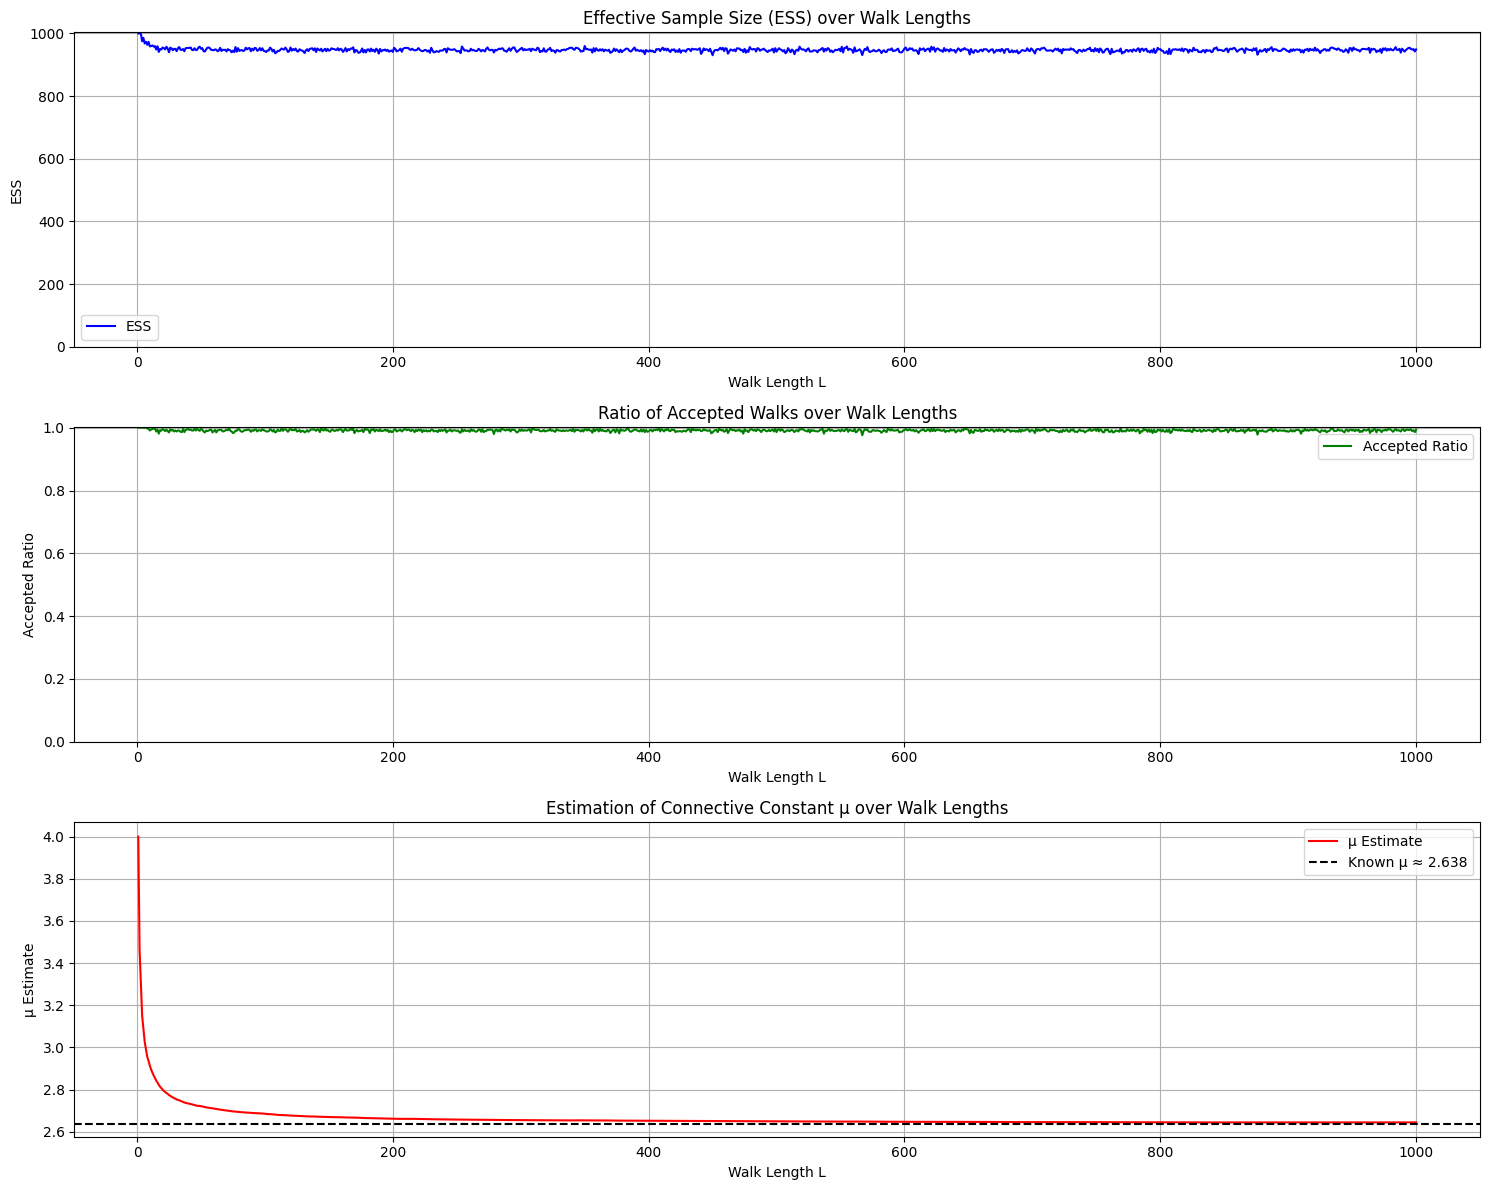

In [16]:
# Plot ESS, Ratio of Accepted Walks, and μ Estimates
plt.figure(figsize=(15, 12))

# Subplot 1: Effective Sample Size (ESS)
plt.subplot(3, 1, 1)
plt.plot(range(1, len(smc.ess_history) + 1), smc.ess_history, label="ESS", color="blue")
plt.xlabel("Walk Length L")
plt.ylabel("ESS")
plt.ylim(bottom=0)
plt.title("Effective Sample Size (ESS) over Walk Lengths")
plt.grid(True)
plt.legend()

# Subplot 2: Ratio of Accepted Walks
plt.subplot(3, 1, 2)
plt.plot(range(1, len(smc.accepted_ratio_history) + 1), smc.accepted_ratio_history, label="Accepted Ratio", color="green")
plt.xlabel("Walk Length L")
plt.ylabel("Accepted Ratio")
plt.ylim(bottom=0)
plt.title("Ratio of Accepted Walks over Walk Lengths")
plt.grid(True)
plt.legend()

# Subplot 3: Estimation of μ
plt.subplot(3, 1, 3)
plt.plot(range(1, len(smc.mu_estimates) + 1), smc.mu_estimates, label="μ Estimate", color="red")
plt.axhline(y=2.638158533032790, color="black", linestyle="--", label="Known μ ≈ 2.638")
plt.xlabel("Walk Length L")
plt.ylabel("μ Estimate")
plt.title("Estimation of Connective Constant μ over Walk Lengths")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("smc.png")
plt.show()